# 증강X + 기본 CNN

# 데이터 불러오기 및 라벨링

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-08-30 14:41:47.246637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:41:47.355943: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4 Physical GPUs, 4 Logical GPUs


2024-08-30 14:41:56.732475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:41:58.351170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14825 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-08-30 14:41:58.352216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14825 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-08-30 14:41:58.353171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:local

In [2]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])

In [3]:
image_paths[0:5]

['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_10.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_100.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_101.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_102.tiff']

In [4]:
print(image_labels[0:50])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
# 라벨 0과 라벨 1의 개수를 계산.
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

(label_0_count, label_1_count)

(534, 391)

# Split the Dataset 6 : 2 : 2 

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [8]:
# 결과 출력
print("Train set:", len(x_train))
print("Validation set:", len(x_val))
print("Test set:", len(x_test))

Train set: 592
Validation set: 148
Test set: 185


In [9]:
print("Normal in Train set:", np.count_nonzero(y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(y_train == 1))

Normal in Train set: 342
Abnormal in Train set: 250


In [10]:
print("image_paths shape:",image_paths.shape)
print("image_labels shape:",image_labels.shape)

image_paths shape: (925,)
image_labels shape: (925,)


### 증강하지 않은 이미지에 대한 CNN모델 적용

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

In [14]:
# 이미지 파일 열기
img = Image.open('/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff')

# 이미지의 너비, 높이 얻기
image_width, image_height = img.size

# 이미지의 채널 수 얻기
num_channels = len(img.getbands())

print('Image Width: ', image_width)
print('Image Height: ', image_height)
print('Number of Channels: ', num_channels)

Image Width:  500
Image Height:  500
Number of Channels:  3


#### 참고문헌: https://www.tensorflow.org/tutorials/images/cnn?hl=ko  

In [15]:
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
strategy = tf.distribute.MirroredStrategy(logical_gpus)

def load_and_preprocess_image(path, target_size=(500, 500)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image


x_train = np.array([load_and_preprocess_image(path) for path in x_train])
x_val = np.array([load_and_preprocess_image(path) for path in x_val])
x_test = np.array([load_and_preprocess_image(path) for path in x_test])

#with tf.device("/gpu:0"):
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:loc

2024-05-05 23:42:40.222797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-05 23:42:40.699975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-05 23:42:43.226322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-05 23:42:43.875736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-05 23:42:44.828606: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-05 23:42:44.833161: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-05-05 23:42:4

 1/19 [>.............................] - ETA: 6:27 - loss: 0.7088 - accuracy: 0.3125

2024-05-05 23:42:50.839728: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-05-05 23:42:50.966530: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


19/19 [==============================] - 27s 304ms/step - loss: 7.1182 - accuracy: 0.5101 - val_loss: 0.6333 - val_accuracy: 0.6351
Epoch 2/30
19/19 [==============================] - 3s 140ms/step - loss: 0.6081 - accuracy: 0.6824 - val_loss: 0.6626 - val_accuracy: 0.5946
Epoch 3/30
19/19 [==============================] - 3s 140ms/step - loss: 0.5822 - accuracy: 0.6858 - val_loss: 0.5941 - val_accuracy: 0.6824
Epoch 4/30
19/19 [==============================] - 3s 146ms/step - loss: 0.5757 - accuracy: 0.7027 - val_loss: 0.5817 - val_accuracy: 0.7095
Epoch 5/30
19/19 [==============================] - 3s 152ms/step - loss: 0.5300 - accuracy: 0.7314 - val_loss: 0.6015 - val_accuracy: 0.6824
Epoch 6/30
19/19 [==============================] - 3s 143ms/step - loss: 0.5057 - accuracy: 0.7449 - val_loss: 0.6070 - val_accuracy: 0.6824
Epoch 7/30
19/19 [==============================] - 3s 147ms/step - loss: 0.5208 - accuracy: 0.7466 - val_loss: 0.5904 - val_accuracy: 0.6689
Epoch 8/30
19/19

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 968256)            0         
                                                                 
 dense (Dense)               (None, 64)                6

5/5 - 0s - loss: 1.0409 - accuracy: 0.6824 - 349ms/epoch - 70ms/step


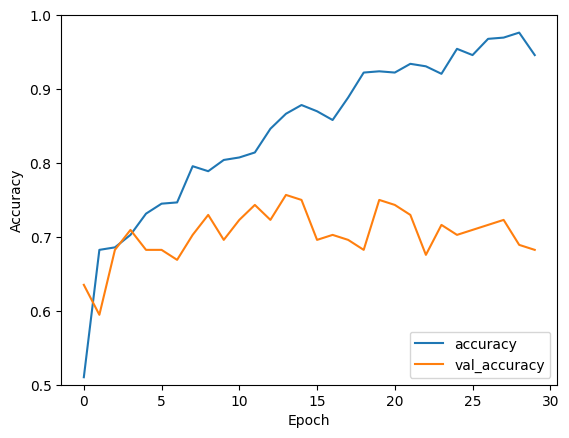

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)